# Full Analysis Notebook

In [52]:

# Setup: imports and paths
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from sklearn.cluster import KMeans
import seaborn as sns
plt.rcParams['figure.dpi'] = 110
sns.set_theme(context='notebook', style='whitegrid')

DATA_PATH = "database_filled1 anonymised.xlsx" 
OUT_DIR = "out"
os.makedirs(OUT_DIR, exist_ok=True)

print("Data path:", DATA_PATH)
print("Output directory:", OUT_DIR)


Data path: database_filled1 anonymised.xlsx
Output directory: out


In [53]:
# Global style configuration (safe initialization)
base_palette = sns.color_palette('tab10')
cluster_palette = sns.color_palette('Set2', 6)
highlight_color = '#d62728'  # consistent highlight (e.g., regression line, threshold)

# Initialize as empty; will be filled after columns are defined
country_palette = {}
group_palette = {}

# Helper to (re)build palettes once `country_cols` and `group_cols` exist
def init_palettes():
    global country_palette, group_palette
    try:
        if 'country_cols' in globals() and isinstance(country_cols, list):
            country_palette = dict(zip(country_cols, base_palette[:len(country_cols)]))
        if 'group_cols' in globals() and isinstance(group_cols, list):
            group_palette = dict(zip(group_cols, sns.color_palette('pastel')[:len(group_cols)]))
    except Exception as e:
        print('Palette init skipped:', e)

# Safe color accessor with fallback
def get_country_color(c):
    return country_palette.get(c, '#808080')

sns.set_context('notebook')


In [54]:

# Load the Excel file
df = pd.read_excel(DATA_PATH)
print("Rows, columns:", df.shape)
display(df.head())
df.info()


Rows, columns: (256, 16)


,Games,Game Prestige Score,Group1,Group2,Group3,Group4,Total Medals,PK,IND,IR,CN,UK,GER,AUS,CAN,USA
0,a1,0.286795,531,158,167,55,1170,0,3,0,49,56,41,9,14,379
1,a2,0.269297,2337,723,256,372,5291,0,8,0,613,117,288,10,258,1484
2,a3,0.267893,1161,392,243,97,2705,1,16,1,110,92,43,23,130,1202
3,a4,0.263658,3072,802,299,632,6996,2,45,13,422,43,133,8,132,2062
4,a5,0.263393,273,72,37,22,616,0,9,0,42,59,29,9,20,196


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Games                256 non-null    object 
 1   Game Prestige Score  256 non-null    float64
 2   Group1               256 non-null    object 
 3   Group2               256 non-null    int64  
 4   Group3               256 non-null    int64  
 5   Group4               256 non-null    int64  
 6   Total Medals         256 non-null    int64  
 7   PK                   256 non-null    int64  
 8   IND                  256 non-null    int64  
 9   IR                   256 non-null    int64  
 10  CN                   256 non-null    int64  
 11  UK                   256 non-null    int64  
 12  GER                  256 non-null    int64  
 13  AUS                  256 non-null    int64  
 14  CAN                  256 non-null    int64  
 15  USA                  256 non-null    int

In [55]:

# --- Data cleaning ---
# Fix Group1 non-numeric entries by extracting leading digits if present
def clean_group1(val):
    s = str(val)
    import re
    m = re.match(r'^\s*([0-9]+)', s.replace(',',''))
    if m:
        return int(m.group(1))
    try:
        return int(float(s))
    except:
        return np.nan

df['Group1'] = df['Group1'].apply(clean_group1).astype('Int64')
# Ensure numeric for other columns
country_cols = ['PK','IND','IR','CN','UK','GER','AUS','CAN','USA']
group_cols = ['Group1','Group2','Group3','Group4']
for c in country_cols + group_cols + ['Total Medals','Game Prestige Score']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Derived columns
df['groups_sum'] = df[group_cols].sum(axis=1)
df['countries_sum'] = df[country_cols].sum(axis=1)
df['pk_share'] = df['PK'] / df['Total Medals'].replace(0, np.nan)
df['prestige_quartile'] = pd.qcut(df['Game Prestige Score'], 4, labels=[1,2,3,4])
df['prestige_decile'] = pd.qcut(df['Game Prestige Score'], 10, labels=False)

# Save cleaned csv
clean_path = os.path.join(OUT_DIR, "database_filled1_cleaned.csv")
df.to_csv(clean_path, index=False)
print("Cleaned data saved to:", clean_path)
df.head()

# Initialize palettes now that columns are known
if 'init_palettes' in globals():
    init_palettes()


Cleaned data saved to: out\database_filled1_cleaned.csv


# PART 1: EXPLORATORY DATA ANALYSIS

In this section, we **discover patterns** through raw distributions, correlations, and visual overviews. The goal is to identify what's interesting in the data before making arguments.

---

## 1.1 Prestige + Group Performance + Country Performance

**Goal:** Understand how game prestige relates to group contributions (Group1-4) and individual country medal counts. Looking for overall trends and patterns across all variables.

In [56]:

# --- Exploratory Data Analysis ---
# Country totals
country_totals = df[country_cols].sum().sort_values(ascending=False)
display(country_totals)

# How many games where PK>0
pk_positive = (df['PK']>0).sum()
pk_positive_pct = pk_positive / len(df) * 100
print(f"PK wins in {pk_positive} games ({pk_positive_pct:.2f}%)")


CN     387810
USA    133119
IND     50289
UK      39760
GER     32544
CAN     29356
AUS     21144
IR      19864
PK       9109
dtype: int64

PK wins in 201 games (78.52%)


In [57]:
# Create plots directory
plots_dir = os.path.join(OUT_DIR, "plots")
os.makedirs(plots_dir, exist_ok=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\195183661.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_means = df.groupby('prestige_quartile')[[c+"_share" for c in country_cols]].mean().T


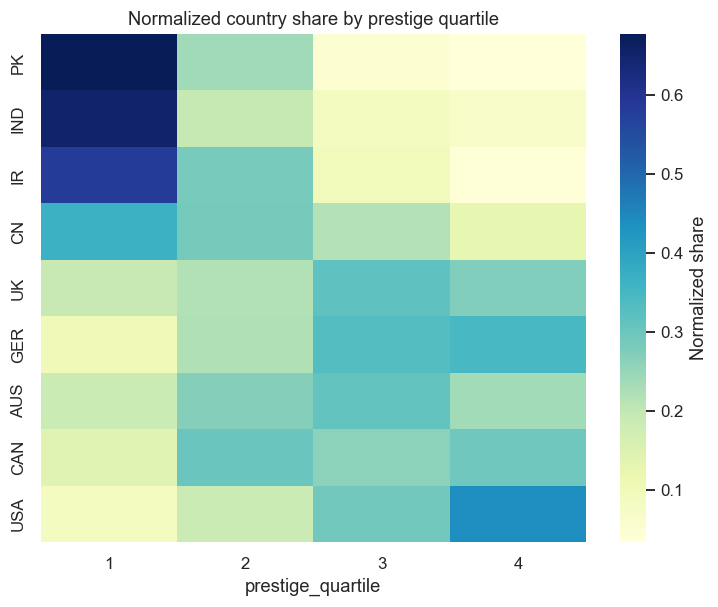

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\195183661.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gshare_means = df.groupby('prestige_quartile')[[f"{g}_gshare" for g in group_cols]].mean().T


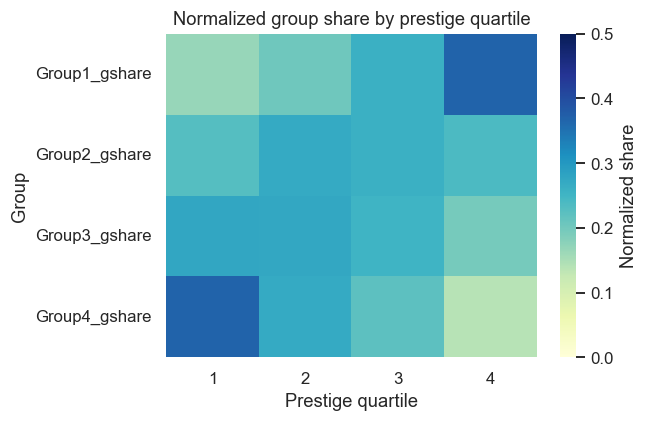

In [73]:
# Country share heatmap (normalized across rows)
for c in country_cols:
    df[c+"_share"] = df[c] / df['Total Medals'].replace(0, np.nan)
share_means = df.groupby('prestige_quartile')[[c+"_share" for c in country_cols]].mean().T
share_means.index = country_cols
normalized = share_means.div(share_means.sum(axis=1), axis=0)
plt.figure(figsize=(8,6))
sns.heatmap(normalized, cmap='YlGnBu', cbar_kws={'label':'Normalized share'})
plt.xticks(rotation=0)
plt.title("Normalized country share by prestige quartile")
plt.savefig(os.path.join(plots_dir, "normalized_country_share_heatmap.png"))
plt.show()


# Group share heatmap (fixed: ensure numeric dtypes before heatmap)
for g in group_cols:
    df[f"{g}_gshare"] = df[g] / df['groups_sum'].replace(0, np.nan)

gshare_means = df.groupby('prestige_quartile')[[f"{g}_gshare" for g in group_cols]].mean().T
gshare_means = gshare_means.apply(pd.to_numeric, errors='coerce').astype(float)
gshare_means = gshare_means.reindex(sorted(gshare_means.columns, key=lambda x: int(x)), axis=1)

gshare_norm = gshare_means.div(gshare_means.sum(axis=1).replace(0, np.nan), axis=0)

plt.figure(figsize=(6,4))
sns.heatmap(gshare_norm, cmap='YlGnBu', cbar_kws={'label': 'Normalized share'}, vmin=0, vmax=0.5)
plt.xlabel("Prestige quartile")
plt.ylabel("Group")
plt.xticks(rotation=0)
plt.title("Normalized group share by prestige quartile")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "normalized_group_share_heatmap.png"))
plt.show()


**Exploration Findings**
- Heatmap shows normalized country shares across prestige quartiles
- It shows out of all medals won, what share each country has in each prestige quartile
- We see that pakistan has most of its share in quartile 1 (meaning lower prestige)

---

## 1.2 PAK vs Group1 Performance

**Goal:** Compare Pakistan's medal performance directly against Group1 to identify if they track together or diverge under different conditions.

In [59]:

# --- Prestige Quartile Analysis ---
country_means_by_quartile = df.groupby('prestige_quartile')[country_cols].mean().T
country_counts_by_quartile = df.groupby('prestige_quartile')[country_cols].sum().T
group_means_by_quartile = df.groupby('prestige_quartile')[group_cols].mean().T

country_means_by_quartile.to_csv(os.path.join(OUT_DIR,"country_means_by_quartile.csv"))
country_counts_by_quartile.to_csv(os.path.join(OUT_DIR,"country_counts_by_quartile.csv"))
group_means_by_quartile.to_csv(os.path.join(OUT_DIR,"group_means_by_quartile.csv"))

display(country_means_by_quartile)
display(group_means_by_quartile)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\671356139.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_means_by_quartile = df.groupby('prestige_quartile')[country_cols].mean().T
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\671356139.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_counts_by_quartile = df.groupby('prestige_quartile')[country_cols].sum().T
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\671356139.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current b

prestige_quartile,1,2,3,4
PK,117.843750,18.015625,4.281250,2.187500
IND,544.875000,147.765625,58.781250,34.343750
IR,195.656250,75.140625,28.343750,11.234375
CN,3316.562500,1419.828125,816.375000,506.765625
UK,177.453125,151.437500,143.968750,148.390625
GER,112.953125,107.781250,128.234375,159.531250
AUS,112.015625,82.921875,75.375000,60.062500
CAN,129.187500,130.078125,99.421875,100.000000
USA,342.171875,376.812500,527.515625,833.484375


prestige_quartile,1,2,3,4
Group1,359.953125,385.828125,528.921875,972.234375
Group2,402.703125,398.609375,418.734375,560.015625
Group3,263.859375,231.859375,237.0,274.71875
Group4,743.609375,421.953125,359.90625,323.5


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\1482890148.py:44: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


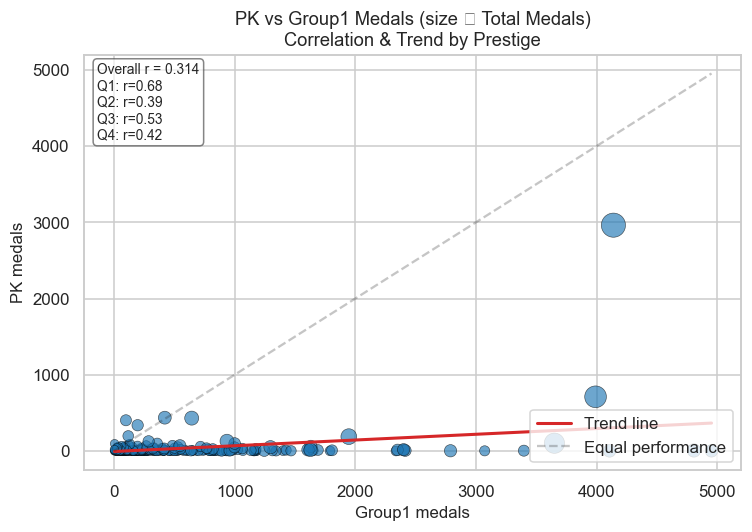

Correlation between PK and Group1 by prestige quartile:
  Quartile 1: 0.683
  Quartile 2: 0.391
  Quartile 3: 0.530
  Quartile 4: 0.422


In [60]:
# Direct scatter: PK vs Group1 (exploration – enhanced)
plt.figure(figsize=(7,5))
# Scaled marker sizes (ensure visibility)
size_scale = (df['Total Medals'].fillna(0) / df['Total Medals'].max())
point_sizes = 30 + size_scale * 220  # 30–250 range

# Scatter
plt.scatter(df['Group1'], df['PK'], s=point_sizes, alpha=0.65,
            color=get_country_color('PK'), edgecolors='black', linewidth=0.4)

# Regression line (least squares)
valid = df[['Group1','PK']].dropna()
if len(valid) > 1:
    coef = np.polyfit(valid['Group1'], valid['PK'], 1)
    xs_line = np.linspace(valid['Group1'].min(), valid['Group1'].max(), 100)
    plt.plot(xs_line, np.poly1d(coef)(xs_line), color=highlight_color, lw=2, label='Trend line')
    slope, intercept = coef[0], coef[1]
else:
    slope, intercept = np.nan, np.nan

# Diagonal reference
max_val = max(df['Group1'].max(), df['PK'].max())
plt.plot([0, max_val],[0,max_val], 'k--', alpha=0.25, label='Equal performance')

# Overall correlation
corr_overall = df['PK'].corr(df['Group1'])
# Correlation by prestige quartile
quartile_corrs = {}
for q in sorted(df['prestige_quartile'].dropna().unique()):
    subset = df[df['prestige_quartile']==q]
    quartile_corrs[int(q)] = subset['PK'].corr(subset['Group1'])

# Annotation block
annot_lines = [f"Overall r = {corr_overall:.3f}"] + [f"Q{q}: r={quartile_corrs[q]:.2f}" for q in sorted(quartile_corrs.keys())]
annot_text = "\n".join(annot_lines)
plt.text(0.02, 0.98, annot_text, transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.65, edgecolor='#444'))

plt.xlabel("Group1 medals", fontsize=11)
plt.ylabel("PK medals", fontsize=11)
plt.title("PK vs Group1 Medals (size ∝ Total Medals)\nCorrelation & Trend by Prestige", fontsize=12)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("Correlation between PK and Group1 by prestige quartile:")
for q, val in sorted(quartile_corrs.items()):
    print(f"  Quartile {q}: {val:.3f}")

**Exploration findings:**
- Prestige quartile analysis shows how both PK and groups distribute across different prestige levels
- There is somewhat moderate correlation between group1 and pk medals

---

## 1.3 PAK Low-Prestige Hypothesis (Discovery)

**Goal:** Explore the distribution of prestige scores for games where Pakistan wins medals vs. where they don't. Looking to discover if there's a pattern suggesting PK performs better in lower-prestige games.

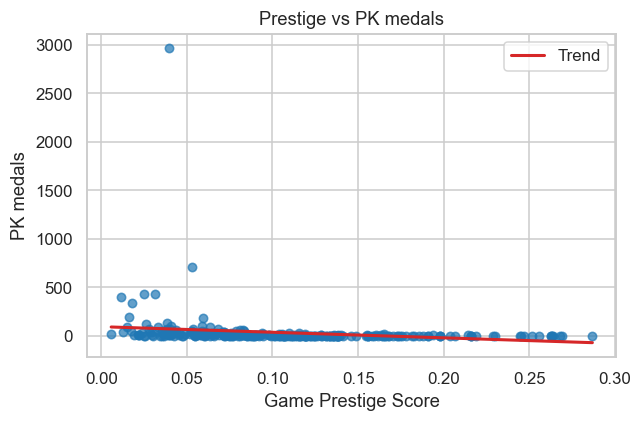

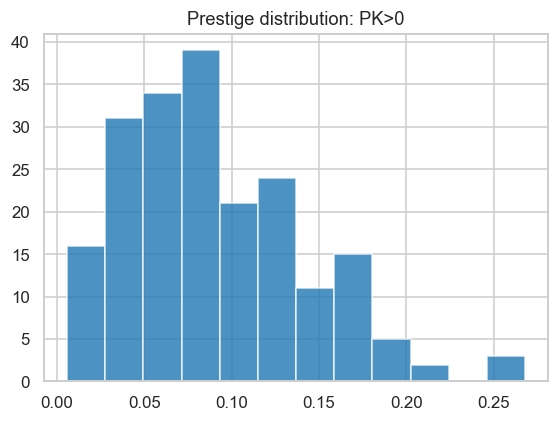

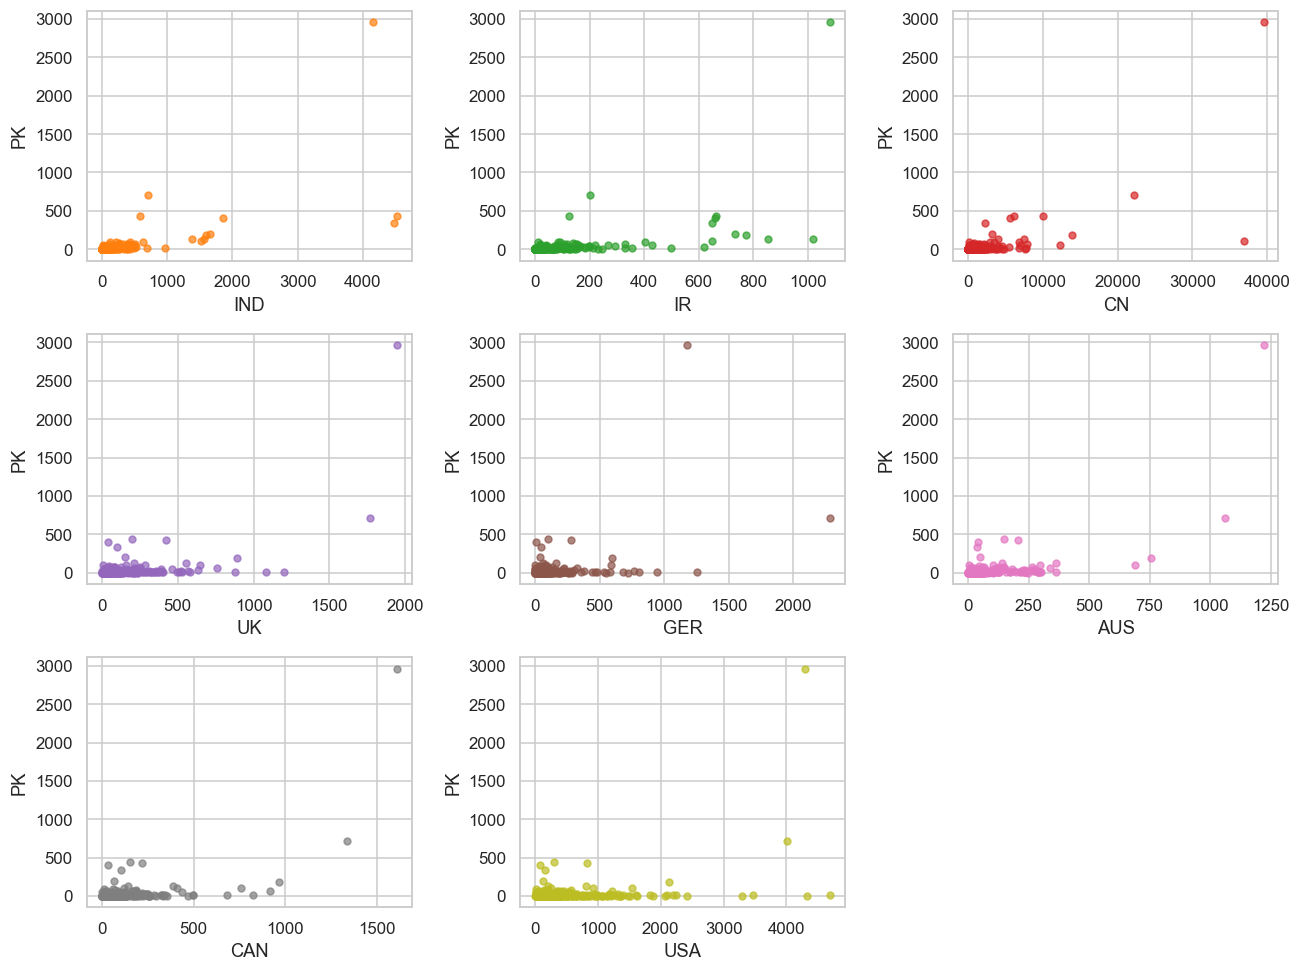

In [61]:

# 1. Prestige vs PK scatter + regression
plt.figure(figsize=(6,4))
plt.scatter(df['Game Prestige Score'], df['PK'], s=30, color=get_country_color('PK'), alpha=0.7)
coef = np.polyfit(df['Game Prestige Score'].fillna(0), df['PK'].fillna(0), 1)
xs = np.linspace(df['Game Prestige Score'].min(), df['Game Prestige Score'].max(), 100)
plt.plot(xs, np.poly1d(coef)(xs), color=highlight_color, linewidth=2, label='Trend')
plt.xlabel("Game Prestige Score"); plt.ylabel("PK medals")
plt.title("Prestige vs PK medals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "prestige_vs_pk.png"))
plt.show()

# 2. Histograms of prestige for PK>0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df.loc[df['PK']>0,'Game Prestige Score'].dropna(), bins=12, color=get_country_color('PK'), alpha=0.8)
plt.title("Prestige distribution: PK>0")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "prestige_hist_pk_pos.png"))
plt.show()

# 3. PK vs each country grid
import math
others = [c for c in country_cols if c!='PK']
n = len(others)
cols = 3; rows = math.ceil(n/cols)
plt.figure(figsize=(12,rows*3))
for i,c in enumerate(others):
    plt.subplot(rows,cols,i+1)
    plt.scatter(df[c], df['PK'], s=20, color=get_country_color(c), alpha=0.7)
    plt.xlabel(c); plt.ylabel("PK")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "pk_vs_each_country_grid.png"))
plt.show()




**Exploration findings:**
- As prestige increases, pakistan's medals decrease
- Pakistan generally has lower medals than every other country 


---

# PART 2: EXPLANATORY ANALYSIS

In this section, we **prove arguments** and **answer specific questions** using derived metrics, statistical evidence, and annotated visualizations. The goal is to make compelling cases based on the patterns discovered in exploration.

---

## 2.1 Prestige + Group Performance + Country Performance (Explained)

In [62]:
# Build country dominance report (needed for dominance visualization)
# Aggregate total medals per country
country_totals = df[country_cols].sum()

# Sum medals per country within each prestige quartile
quartile_country_sums = df.groupby('prestige_quartile')[country_cols].sum()

# Compute share of each country's total medals that come from each quartile
shares = quartile_country_sums.div(country_totals.replace(0, np.nan), axis=1)

# Assemble report_df
report_df = pd.DataFrame({'Country': country_totals.index, 'Total_Medals': country_totals.values})
for q in quartile_country_sums.index:
    report_df[f'Share_Q{int(q)}'] = shares.loc[q].values

# Determine dominant quartile (highest share)
share_cols = [c for c in report_df.columns if c.startswith('Share_Q')]
report_df['Dominant_Quartile'] = report_df[share_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(int)

# Sort by total medals for consistent plotting
report_df = report_df.sort_values('Total_Medals', ascending=False).reset_index(drop=True)

# Persist to disk
report_path = os.path.join(OUT_DIR, 'country_dominance_report.csv')
report_df.to_csv(report_path, index=False)
print('Saved dominance report to:', report_path)

display(report_df)

Saved dominance report to: out\country_dominance_report.csv


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\1584055844.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_country_sums = df.groupby('prestige_quartile')[country_cols].sum()


,Country,Total_Medals,Share_Q1,Share_Q2,Share_Q3,Share_Q4,Dominant_Quartile
0,CN,387810,0.547330,0.234313,0.134726,0.083631,1
1,USA,133119,0.164507,0.181161,0.253615,0.400717,4
2,IND,50289,0.693432,0.188053,0.074808,0.043707,1
3,UK,39760,0.285639,0.243763,0.231740,0.238858,1
4,GER,32544,0.222130,0.211959,0.252182,0.313729,4
5,CAN,29356,0.281646,0.283588,0.216753,0.218013,2
6,AUS,21144,0.339056,0.250993,0.228150,0.181801,1
7,IR,19864,0.630387,0.242096,0.091321,0.036196,1
8,PK,9109,0.827972,0.126578,0.030080,0.015369,1


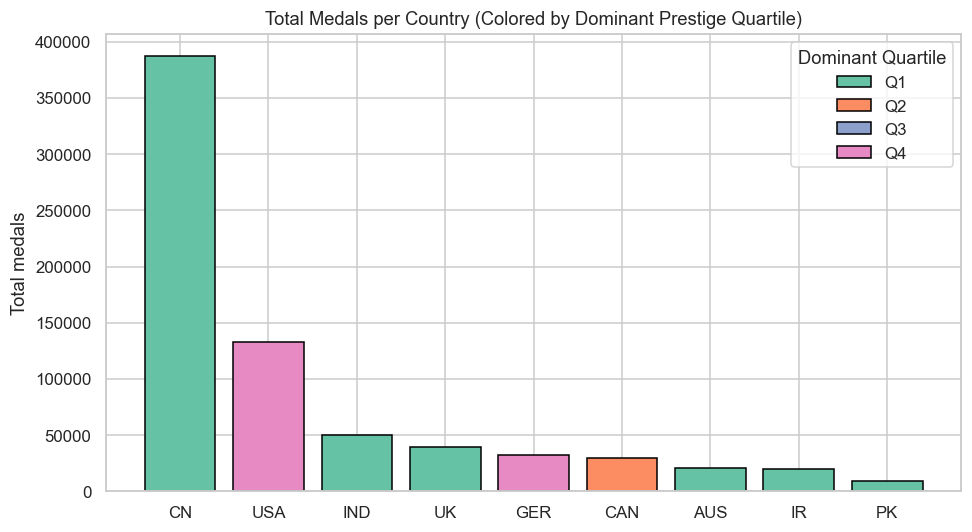

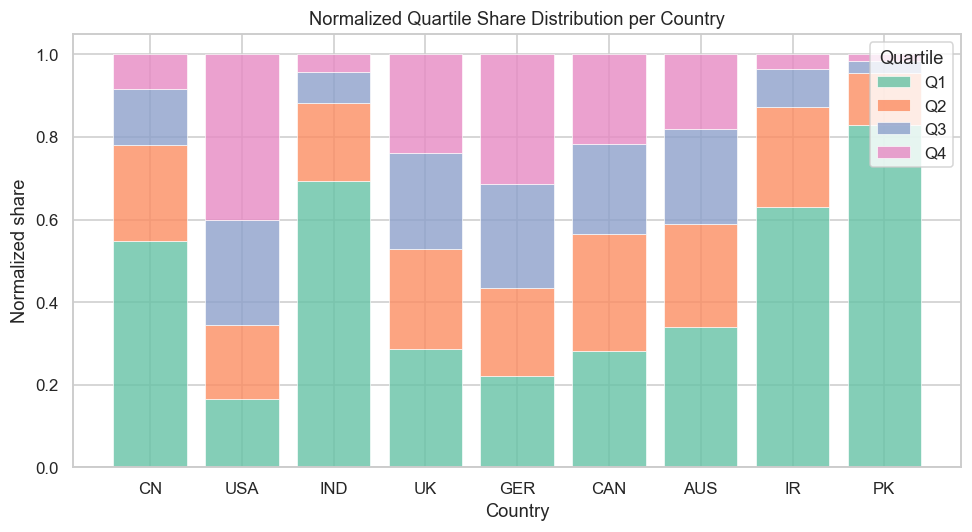

In [63]:
from matplotlib.patches import Patch

# --- Visualizing Country Dominance Report (Unified Palette) ---
plot_df = report_df.reset_index()
plt.figure(figsize=(9,5))
# Color bars by dominant quartile instead of country
quartile_colors_bar = sns.color_palette('Set2', 4)
bar_colors = [quartile_colors_bar[dq-1] for dq in plot_df['Dominant_Quartile']]
bars = plt.bar(plot_df['Country'], plot_df['Total_Medals'], color=bar_colors, edgecolor='black')
plt.title('Total Medals per Country (Colored by Dominant Prestige Quartile)')
plt.ylabel('Total medals')
# Add legend for quartiles
legend_elements = [Patch(facecolor=quartile_colors_bar[i], edgecolor='black', label=f'Q{i+1}') for i in range(4)]
plt.legend(handles=legend_elements, title='Dominant Quartile', loc='upper right')
plt.tight_layout()
plt.show()

# Stacked normalized shares across quartiles (consistent quartile palette)
share_cols = ['Share_Q1','Share_Q2','Share_Q3','Share_Q4']
share_stack = plot_df[['Country'] + share_cols].set_index('Country')
share_stack_norm = share_stack.div(share_stack.sum(axis=1).replace(0, np.nan), axis=0)
quartile_colors = sns.color_palette('Set2', 4)
bottom = np.zeros(len(share_stack_norm))
plt.figure(figsize=(9,5))
for i, col in enumerate(share_cols):
    plt.bar(share_stack_norm.index, share_stack_norm[col], bottom=bottom, color=quartile_colors[i], alpha=0.8, edgecolor='white', linewidth=0.5, label=f'Q{i+1}')
    bottom += share_stack_norm[col].values
plt.title('Normalized Quartile Share Distribution per Country')
plt.ylabel('Normalized share')
plt.xlabel('Country')
plt.legend(title='Quartile', loc='upper right')
plt.tight_layout()
plt.show()


**Explanation evidence:**
- We see the medal counts of each country, along with the prestige quartile they dominated, higher quartile being a higher prestige level range
- Normalized stacked shares prove which countries concentrate in which prestige tiers
- Key Insight: Each country has a prestige "sweet spot" where they win disproportionately more medals

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\2144126646.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_group_sums = df.groupby('prestige_quartile')[group_cols].sum()  # rows: quartile, cols: groups


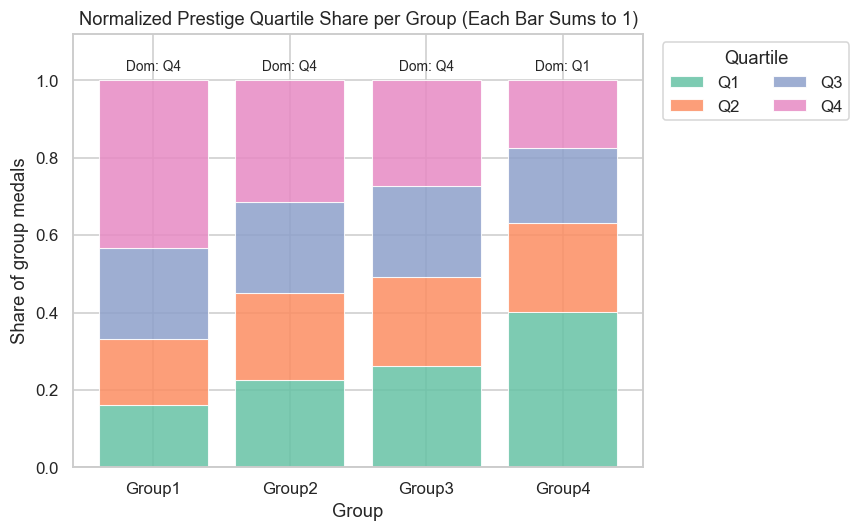

prestige_quartile,1,2,3,4,Dominant_Quartile
Group1,0.160197,0.171713,0.235397,0.432693,4
Group2,0.22623,0.22393,0.235236,0.314604,4
Group3,0.261911,0.230148,0.23525,0.272691,4
Group4,0.402175,0.22821,0.194652,0.174962,1


In [64]:
# --- Group Quartile Share Distribution (Normalized Stacked Bars) ---
# Similar to country dominance shares, but for Group1–Group4: shows what share of each group's total medals
# comes from each prestige quartile (each bar sums to 1 across quartiles).

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

if {'prestige_quartile'}.issubset(df.columns):
    group_totals = df[group_cols].sum()
    quartile_group_sums = df.groupby('prestige_quartile')[group_cols].sum()  # rows: quartile, cols: groups
    group_shares = quartile_group_sums.div(group_totals.replace(0, np.nan), axis=1)  # fraction of each group's medals from each quartile
    share_matrix = group_shares.T  # rows: group, cols: quartile

    # Determine dominant quartile per group
    dominant_q = share_matrix.idxmax(axis=1)

    plt.figure(figsize=(8,5))
    quartile_colors = sns.color_palette('Set2', len(share_matrix.columns))
    bottom = np.zeros(len(share_matrix))
    for i, q in enumerate(sorted(share_matrix.columns, key=lambda x: int(x))):
        vals = share_matrix[q].values.astype(float)
        plt.bar(share_matrix.index, vals, bottom=bottom, color=quartile_colors[int(q)-1],
                edgecolor='white', linewidth=0.7, alpha=0.85, label=f'Q{int(q)}')
        bottom += vals

    # Annotate dominant quartile atop bars
    for idx, g in enumerate(share_matrix.index):
        dq = dominant_q[g]
        plt.text(idx, 1.02, f"Dom: Q{int(dq)}", ha='center', va='bottom', fontsize=9)

    plt.title('Normalized Prestige Quartile Share per Group (Each Bar Sums to 1)')
    plt.ylabel('Share of group medals')
    plt.xlabel('Group')
    plt.ylim(0, 1.12)
    plt.legend(title='Quartile', ncol=2, loc='upper left', bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()

    # Tabular view
    display(share_matrix.round(3).assign(Dominant_Quartile=dominant_q.apply(lambda x: int(x))))
else:
    print('prestige_quartile column missing; cannot compute group quartile shares.')


**Group Quartile Share Interpretation**

- We can see that each group 1 to 3 has a higher share of medals in quartile 4 i.e. higher prestige games.
- Group 4, however has a higher share of medals in group 1.


---

## 2.2 PAK vs Group1 Performance (Proven Comparison)

**Argument:** Pakistan's performance relative to Group1 varies systematically by game prestige. Understanding this ratio reveals competitive windows.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21588\1482890148.py:44: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


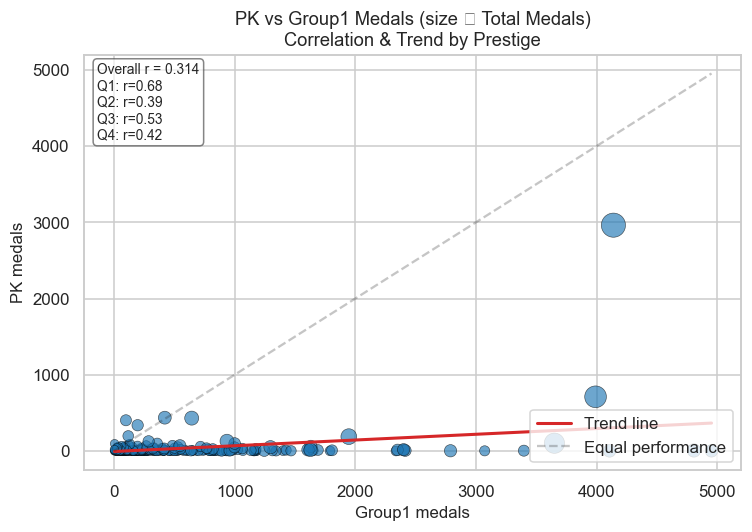

Correlation between PK and Group1 by prestige quartile:
  Quartile 1: 0.683
  Quartile 2: 0.391
  Quartile 3: 0.530
  Quartile 4: 0.422


In [65]:
# Direct scatter: PK vs Group1 (exploration – enhanced)
plt.figure(figsize=(7,5))
# Scaled marker sizes (ensure visibility)
size_scale = (df['Total Medals'].fillna(0) / df['Total Medals'].max())
point_sizes = 30 + size_scale * 220  # 30–250 range

# Scatter
plt.scatter(df['Group1'], df['PK'], s=point_sizes, alpha=0.65,
            color=get_country_color('PK'), edgecolors='black', linewidth=0.4)

# Regression line (least squares)
valid = df[['Group1','PK']].dropna()
if len(valid) > 1:
    coef = np.polyfit(valid['Group1'], valid['PK'], 1)
    xs_line = np.linspace(valid['Group1'].min(), valid['Group1'].max(), 100)
    plt.plot(xs_line, np.poly1d(coef)(xs_line), color=highlight_color, lw=2, label='Trend line')
    slope, intercept = coef[0], coef[1]
else:
    slope, intercept = np.nan, np.nan

# Diagonal reference
max_val = max(df['Group1'].max(), df['PK'].max())
plt.plot([0, max_val],[0,max_val], 'k--', alpha=0.25, label='Equal performance')

# Overall correlation
corr_overall = df['PK'].corr(df['Group1'])
# Correlation by prestige quartile
quartile_corrs = {}
for q in sorted(df['prestige_quartile'].dropna().unique()):
    subset = df[df['prestige_quartile']==q]
    quartile_corrs[int(q)] = subset['PK'].corr(subset['Group1'])

# Annotation block
annot_lines = [f"Overall r = {corr_overall:.3f}"] + [f"Q{q}: r={quartile_corrs[q]:.2f}" for q in sorted(quartile_corrs.keys())]
annot_text = "\n".join(annot_lines)
plt.text(0.02, 0.98, annot_text, transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.65, edgecolor='#444'))

plt.xlabel("Group1 medals", fontsize=11)
plt.ylabel("PK medals", fontsize=11)
plt.title("PK vs Group1 Medals (size ∝ Total Medals)\nCorrelation & Trend by Prestige", fontsize=12)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("Correlation between PK and Group1 by prestige quartile:")
for q, val in sorted(quartile_corrs.items()):
    print(f"  Quartile {q}: {val:.3f}")

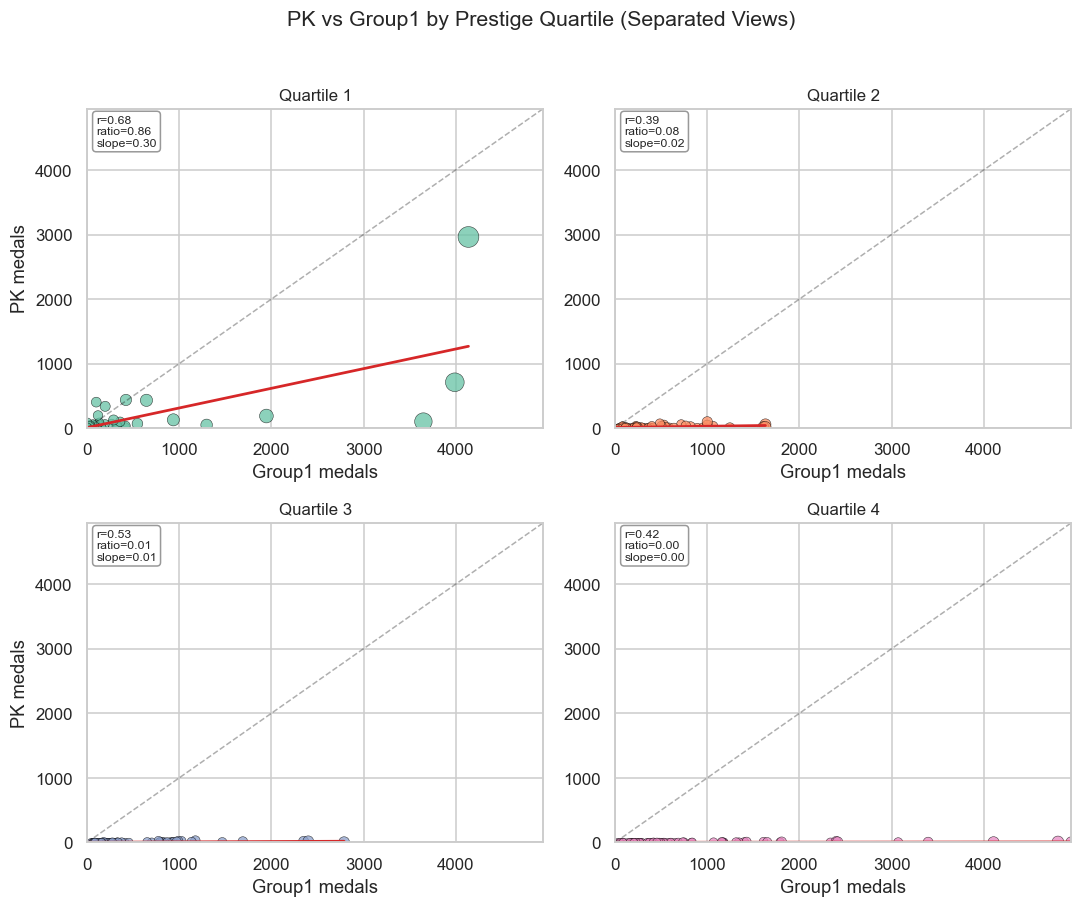

,Quartile,Games,Mean_PK,Mean_Group1,Mean_Ratio_PK_G1,Corr_r,Slope
0,1,64,117.84,359.95,0.859,0.683,0.304
1,2,64,18.02,385.83,0.077,0.391,0.019
2,3,64,4.28,528.92,0.009,0.530,0.006
3,4,64,2.19,972.23,0.003,0.422,0.001


In [66]:
# --- Explanatory Small-Multiples Scatter: PK vs Group1 by Prestige Quartile ---
# Shows raw relationship separately per quartile, enabling direct comparison of slope, spread, ratio and correlation.
# Annotations: Pearson r, mean ratio PK/G1, linear slope.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

if {'PK','Group1','prestige_quartile','Total Medals'}.issubset(df.columns):
    scatter_source = df[['PK','Group1','prestige_quartile','Total Medals']].dropna()
    quartiles = sorted(scatter_source['prestige_quartile'].unique())
    n_q = len(quartiles)
    cols = 2
    rows = int(np.ceil(n_q / cols))
    g1_max = scatter_source['Group1'].max()
    pk_max = scatter_source['PK'].max()
    size_scale = (scatter_source['Total Medals'] / scatter_source['Total Medals'].max()).clip(0,1)
    colors_q = sns.color_palette('Set2', 4)

    plt.figure(figsize=(10, 4.2*rows))
    for i, q in enumerate(quartiles, start=1):
        ax = plt.subplot(rows, cols, i)
        sub = scatter_source[scatter_source['prestige_quartile']==q]
        sizes = 25 + size_scale.loc[sub.index]*160
        ax.scatter(sub['Group1'], sub['PK'], s=sizes, alpha=0.75,
                   color=colors_q[int(q)-1], edgecolors='black', linewidth=0.35)
        # Equality line
        lim_max = max(g1_max, pk_max)
        ax.plot([0, lim_max],[0, lim_max], 'k--', lw=1, alpha=0.35)
        # Linear fit
        if len(sub) > 1:
            coef = np.polyfit(sub['Group1'], sub['PK'], 1)
            xs = np.linspace(0, sub['Group1'].max(), 90)
            ax.plot(xs, np.poly1d(coef)(xs), color=highlight_color, lw=1.8)
            slope = coef[0]
            r = sub['Group1'].corr(sub['PK'])
            ratio_mean = (sub['PK'] / sub['Group1'].replace(0, np.nan)).mean()
        else:
            slope = np.nan; r = np.nan; ratio_mean = np.nan
        # Annotation
        txt = f"r={r:.2f}\nratio={ratio_mean:.2f}\nslope={slope:.2f}"
        ax.text(0.02, 0.98, txt, transform=ax.transAxes, va='top', ha='left', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.60, edgecolor='#555'))
        ax.set_title(f"Quartile {int(q)}", fontsize=11)
        ax.set_xlim(0, lim_max)
        ax.set_ylim(0, lim_max)
        if i % cols == 1:
            ax.set_ylabel('PK medals')
        ax.set_xlabel('Group1 medals')
    plt.suptitle('PK vs Group1 by Prestige Quartile (Separated Views)', fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    # Tabular summary for clarity
    summary_rows = []
    for q in quartiles:
        sub = scatter_source[scatter_source['prestige_quartile']==q]
        r = sub['Group1'].corr(sub['PK']) if len(sub)>1 else np.nan
        ratio_mean = (sub['PK'] / sub['Group1'].replace(0, np.nan)).mean()
        slope = np.polyfit(sub['Group1'], sub['PK'], 1)[0] if len(sub)>1 else np.nan
        summary_rows.append({'Quartile': int(q), 'Games': len(sub), 'Mean_PK': sub['PK'].mean(),
                             'Mean_Group1': sub['Group1'].mean(), 'Mean_Ratio_PK_G1': ratio_mean,
                             'Corr_r': r, 'Slope': slope})
    summary_df = pd.DataFrame(summary_rows)
    display(summary_df.round({'Mean_PK':2,'Mean_Group1':2,'Mean_Ratio_PK_G1':3,'Corr_r':3,'Slope':3}))
else:
    print('Required columns missing for small-multiples scatter.')


**Explantion Evidence**
- There is a moderate correlation between Group1 and PK medals, meaning that when Group1 performs better, Pakistan tends to also win more medals, but the relationship is not perfectly strong.
- This suggests that while PK's success is somewhat linked to Group1's overall performance, other factors or groups may also play a role in PK's medal outcomes.